# Pattern analysis
----

Analys of unexpected pattern found with $\texttt{UnexPattern}$ algorithm

**Libraries**

In [226]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

## Pattern extent/intent sizes  
---

We compare sizes of pattern (respectively the length of their extent and intent) considering if the list of attributes in $\texttt{UnexPattern}$ algorithm has been sorted or not.

In [12]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')

**Load data**

We use unexpected patterns generated with minimum support values for nodes and attributes $s=5$ and $\beta=5$.

In [215]:
dataset = 'wikivitals'
s = 5
beta = 5

sorted_attributes = True

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result_ordered = pickle.load(data)
    
sorted_attributes = False

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result_not_ordered = pickle.load(data)

**Pattern size distributions**

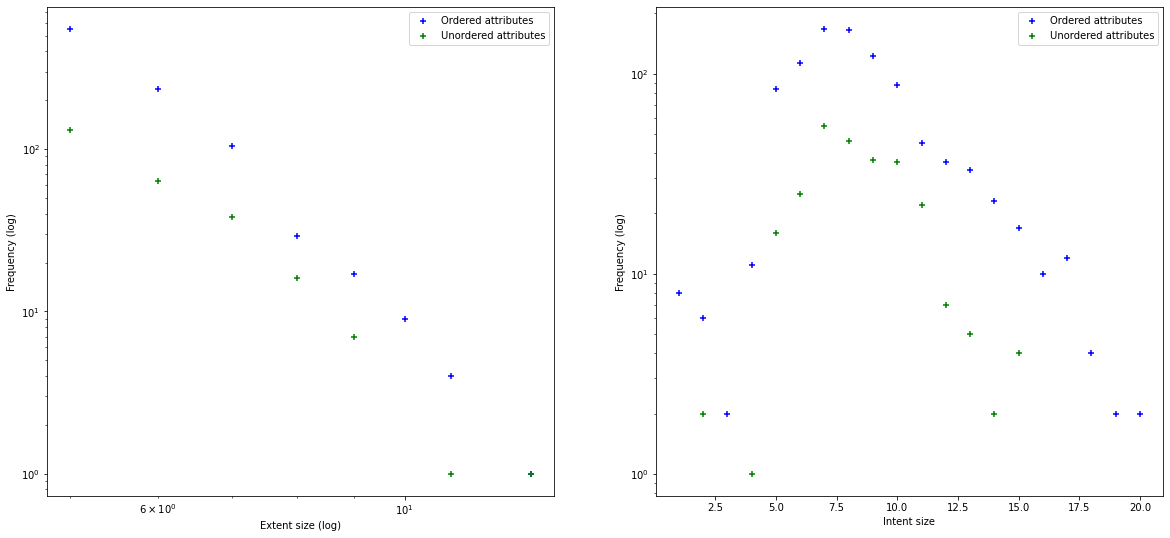

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax[0], xlabel='Extent size', color='blue', label='Ordered attributes')
plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[0], xlabel='Extent size', color='green', label='Unordered attributes')
plot_distrib([len(p[1]) for p in result_ordered if len(p[1]) > 0], ax=ax[1], xlabel='Intent size', log=False, color='blue', label='Ordered attributes')
plot_distrib([len(p[1]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[1], xlabel='Intent size', log=False, color='green', label='Unordered attributes')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


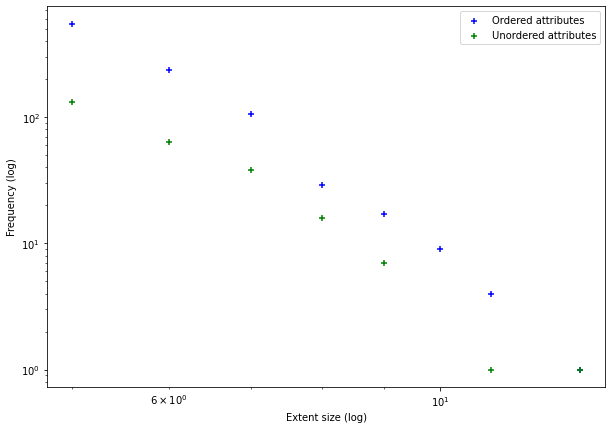

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax, xlabel='Extent size', color='blue', label='Ordered attributes')
plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax, xlabel='Extent size', color='green', label='Unordered attributes')
plt.savefig(f'../output/img/extent_size_distrib.eps', dpi=300)

**All datasets**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


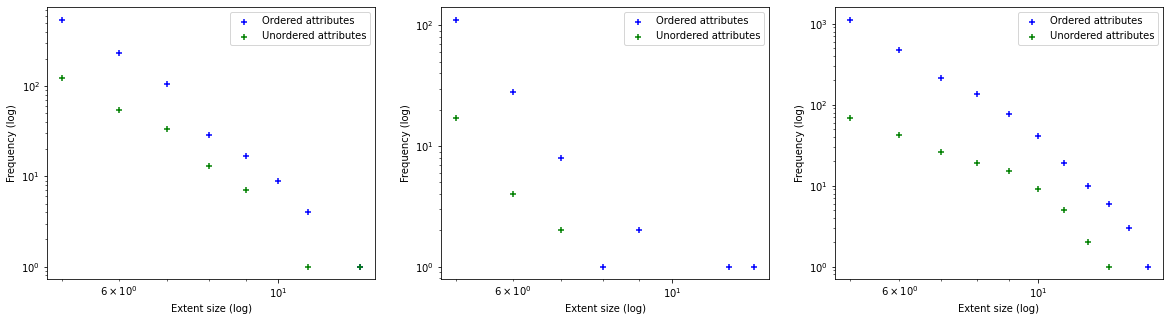

In [89]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
s = 5
beta = 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, dataset in enumerate(datasets):

    sorted_attributes = True

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}.bin", "rb") as data:
        result_ordered = pickle.load(data)

    sorted_attributes = False

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
        result_not_ordered = pickle.load(data)
        
    # plot results
    plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax[i], xlabel='Extent size', color='blue', label='Ordered attributes')
    plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[i], xlabel='Extent size', color='green', label='Unordered attributes')
    
plt.savefig(f'../output/img/extent_size_distrib_all_datasets.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


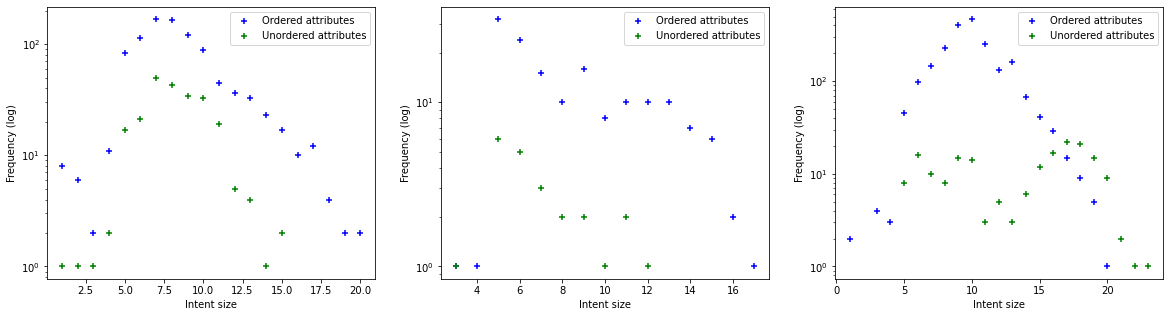

In [90]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
s = 5
beta = 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, dataset in enumerate(datasets):

    sorted_attributes = True

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}.bin", "rb") as data:
        result_ordered = pickle.load(data)

    sorted_attributes = False

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
        result_not_ordered = pickle.load(data)
        
    # plot results
    plot_distrib([len(p[1]) for p in result_ordered if len(p[1]) > 0], ax=ax[i], log=False, xlabel='Intent size', color='blue', label='Ordered attributes')
    plot_distrib([len(p[1]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[i], log=False, xlabel='Intent size', color='green', label='Unordered attributes')
    
plt.savefig(f'../output/img/intent_size_distrib_all_datasets.eps', dpi=300)

## Ordering attributes impact

In [348]:
# max_support = 100
logs = {'wikivitals': {
    'ordered attributes': {'beta_8': [12.87, 26.76, 63.87, 76.57],
               'beta_7': [28.24, 43.26, 84.10, 169.37],
               'beta_6': [15.93, 29.57, 128.29, 242.44],
               'beta_5': [31.22, 66.90, 185.98, 438.22]},
    'unordered attributes': {'beta_8': [8.07, 17.13, 9.65, 13.51],
                   'beta_7': [10.29, 17.34, 30.25, 58.07],
                   'beta_6': [10.90, 15.34, 40.62, 63.93],
                   'beta_5': [18.10, 34.24, 66.73, 155.92]}
 },
 'wikivitals-fr': {
     'ordered attributes': {'beta_8': [6.42, 8.56, 14.30, 26.73],
               'beta_7': [6.70, 8.76, 14.04, 30.79],
               'beta_6': [6.34, 9.96, 17.06, 40.24],
               'beta_5': [6.56, 10.23, 19.24, 72.03]},
    'unordered attributes': {'beta_8': [5.10, 5.75, 6.05, 8.79],
                   'beta_7': [5.12, 5.95, 6.44, 9.48],
                   'beta_6': [4.69, 6.03, 6.88, 11.82],
                   'beta_5': [5.08, 6.47, 8.49, 19.69]}
     
 },
 'wikischools': {
     'ordered attributes': {'beta_8': [4.02, 15.84, 30.40, 55.26],
               'beta_7': [20.60, 24.44, 73.25, 153.18],
               'beta_6': [30.33, 50.34, 93.09, 233.96],
               'beta_5': [45.44, 105.43, 203.66, 456.00]},
    'unordered attributes': {'beta_8': [2.56, 3.05, 4.06, 6.96],
                   'beta_7': [4.41, 11.94, 7.68, 51.63],
                   'beta_6': [9.70, 17.34, 28.63, 58.86],
                   'beta_5': [18.87, 28.42, 33.58, 60.44]}
 }
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


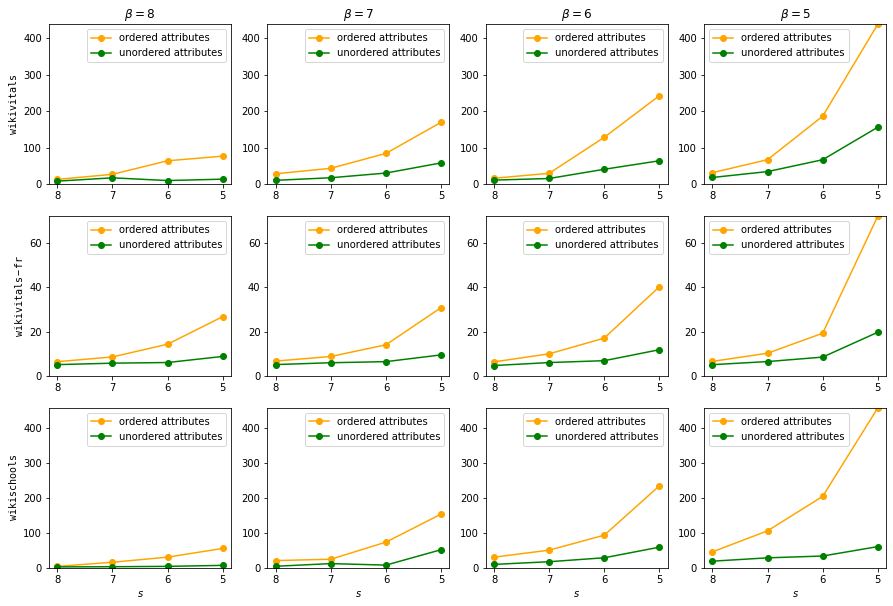

In [195]:
betas = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
orderings = ['ordered attributes', 'unordered attributes']
colors = ['orange', 'green']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, o in enumerate(orderings):
            vals = logs.get(dataset).get(o).get(b)
            ax[d, i].plot(vals, marker='o', label=o, color=colors[j])
            ax[d, i].set_xticks(np.arange(0, len(betas)), labels=['8', '7', '6', '5'])
            ax[d, i].legend()
            beta = b.split('_')[1]
            if d == 0:
                ax[d, i].set_title(rf"$\beta={beta}$")
            if d == len(datasets) - 1:
                ax[d, i].set_xlabel('$s$')
            max_y = max(max_y, np.max(vals))
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(0, max_y)
        
    ax[d, 0].set_ylabel(rf"$\tt{dataset}$")
    
# Save image
plt.savefig('../output/img/attribute_ordering.eps', dpi=200, bbox_inches='tight')

## Number of patterns with/without using Unexpectedness measure

We run the UnexPAttern algorithm without unexpectedness constraint and compare number of patterns found with result using unexpectedness.

In [344]:
# Without unexpectedness
import pickle


with open('../number_of_patterns_history.pkl', 'rb') as f:
    history = pickle.load(f)

history

defaultdict(dict,
            {'wikivitals': defaultdict(dict,
                         {False: defaultdict(list,
                                      {8: [6, 20, 52, 114],
                                       7: [7, 27, 78, 186],
                                       6: [7, 27, 78, 187],
                                       5: [27, 74, 168, 365]}),
                          True: defaultdict(list,
                                      {8: [12, 53, 175, 480],
                                       7: [79, 207, 492, 1080],
                                       6: [94, 249, 603, 1379],
                                       5: [126, 341, 829, 1928]})}),
             'wikivitals-fr': defaultdict(dict,
                         {False: defaultdict(list,
                                      {8: [1, 2, 4, 14],
                                       7: [1, 2, 4, 15],
                                       6: [1, 2, 5, 19],
                                       5: [1, 3, 9, 35]}),
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


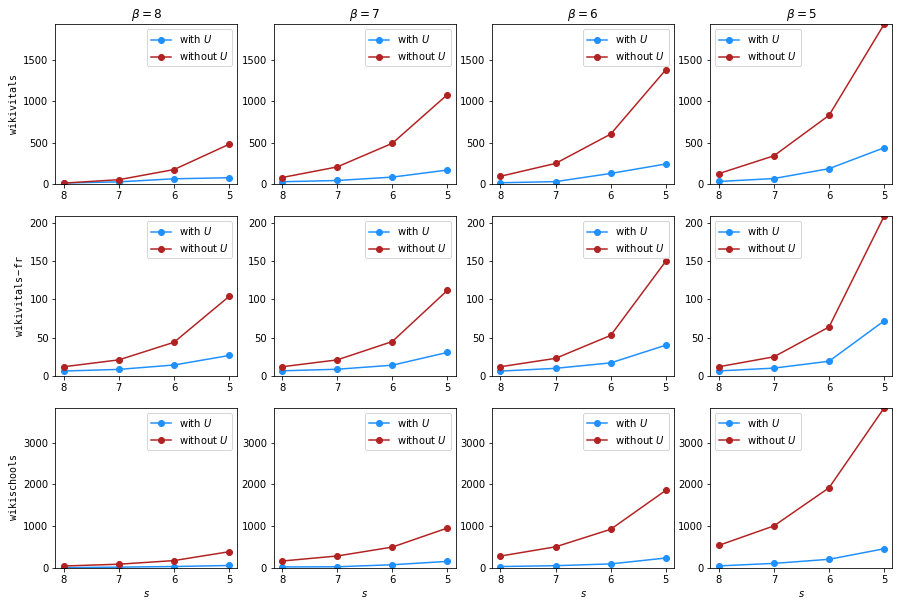

In [367]:
betas = [8, 7, 6, 5]
betas_log = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
ticks_labels = ['8', '7', '6', '5']
with_unex = [True, False]
colors = ['dodgerblue', 'firebrick']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, u in enumerate(with_unex):
            if u:
                vals = logs.get(dataset).get('ordered attributes').get(betas_log[i])
                lab = rf'with $U$'
            else:
                vals = history.get(dataset).get(True).get(b)
                lab = rf'without $U$'
            ax[d, i].plot(vals, marker='o', label=lab, color=colors[j])
            ax[d, i].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
            ax[d, i].legend()
            beta = str(b) #b.split('_')[1]
            if d == 0:
                ax[d, i].set_title(rf"$\beta={beta}$")
            if d == len(datasets) - 1:
                ax[d, i].set_xlabel('$s$')
            max_y = max(max_y, np.max(vals))
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(0, max_y)
        
    ax[d, 0].set_ylabel(rf"$\tt{dataset}$")
    
# Save image
plt.savefig('../output/img/unexpectedness_ablation.eps', dpi=200, bbox_inches='tight')

## Explainable patterns (RQ2)

Load patterns found with parameters $s=\beta=5$ on $\texttt{wikischools}$ dataset.

In [217]:
def get_summarized_graph(adjacency, concepts):
    """Get summarized graph given concepts and original adjacency matrix."""
    
    rows, cols = [], []

    for c in concepts:

        # exclude first element of lattice 
        if len(c[1]) > 0:
            nodes = sorted(c[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_concept = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [306]:
dataset = 'wikischools'
s = 5
beta = 5
sorted_attributes = True

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result = pickle.load(data)
    
print(len(result))

2914


In [307]:
# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
if order_attributes:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

Parsing files...
Done.


In [308]:
# Summarized graph
summarized_adjacency = get_summarized_graph(adjacency, result)
summarized_adjacency

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

561


**Connected components in summarized graph**

In [309]:
labels_cc_summarized = get_connected_components(summarized_adjacency)
len(np.unique(labels_cc_summarized))

3877

In [310]:
{i: n for i, n in enumerate(names) if 'Nicaea' in n}

{884: 'First Council of Nicaea'}

In [311]:
for c in result[1:]:
    if 884 in c[0]:
        print(c[0], c[1])

[294, 364, 548, 884, 998, 3027] [1812, 4041, 8453, 8561, 8740]
[294, 364, 548, 884, 3027] [1812, 4041, 8453, 8561, 8572, 8740]


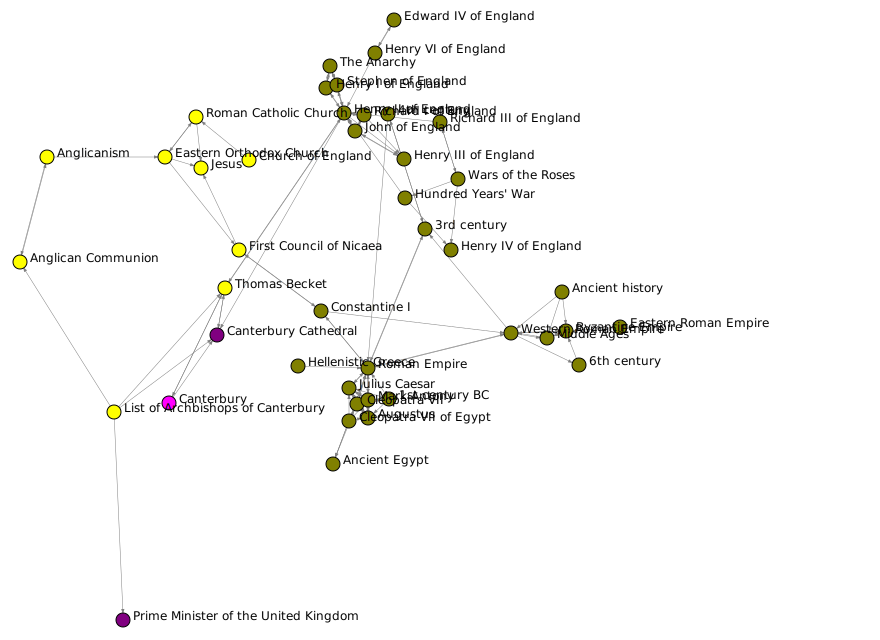

In [318]:
# Find random connected component
sorted(Counter(labels_cc_summarized).items(), key=lambda x: x[1], reverse=True)[0]

# Plot connected components
mask_cc = labels_cc_summarized == 101
g = summarized_adjacency#[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=600, height=600, labels=labels[mask_cc]))

In [319]:
found_concepts = []
nodes = np.flatnonzero(mask_cc)
for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in nodes:
                found_concepts.append(c)
                break

In [343]:
# Print related concepts
random_idxs = np.random.choice(len(found_concepts), 75)
for c in np.array(found_concepts, dtype=object)[random_idxs]:
    if "Prime Minister of the United Kingdom" in names[c[0]]:
        print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
        print()

['Anglicanism' 'Eastern Orthodox Church'
 'Prime Minister of the United Kingdom' 'Anglican Communion'
 'List of Archbishops of Canterbury'] - ['pare' 'primu' 'inter' 'equal' 'among']

